In [4]:
#purpose is to generate images in the steps below, first collecting some files
'''
Paths and file needs:
*imglams and spitzer_conversions are excel files, right now I have it so you need to put it as same directory as your code (but could later maybe just give it a path to go to - would be smarter)
*paths to images and data in general
'''
#now the steps
'''
1) read in all the data by noting all the paths to given spitzer and hubble images
2) loop through all the data, read it in, convert units
3) cutout all the data as appropriate
3) create a loop or otherwise hardcode going through all the combinations of convolutions of images by hand...
4) regrid all the images
5) de-extinct all the images
6) create apertures as appropriate for all the knots
7) perform relevant analyses: e.g. taking ratio and then finding EDFs, summing up the intensities of each knot for noting and saving
'''

#just to check python version - should be 3.7.4
from platform import python_version
print(python_version())

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

import glob
import itertools
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

%matplotlib inline

3.8.5


In [5]:
# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names


'''now convolve my image with a PSF of the image we're projecting ONTO
an approx PSF can be found by assuming a 2D Gaussian func with a width (a FWHM) of the diffrac limit
that is the st dev of the Gaussian is about the st dev is about = lambda/D
a list of PSFs are found on https://docs.astropy.org/en/stable/convolution/kernels.html

Notes:
FIRST: always must convert hdu1_pixtorad to radians! It's inconsistent otherwise, and lambda/D is generally in radians

what we're using for the gaussian width is the FWHM, not the radius of the first ring of the diffraction pattern,
so it's 1.2 not 1.22 times lambda/D

D is 85 cm for spitzer
D is 2.4 m for hubble
'''

def im_conv(D, hdu_pix_torad, hdu_dat, lam, kern):
    #gaussian kernel
    if kern == 'gauss':
        #update: usually cannot find wavelength but these headers are well-labeled    
        #finding angular resolution...the FWHM of our Gaussian PSF
        res = 1.2 * lam / D         #resolution in radians
        res = res / hdu_pix_torad        #so converting to pixels

        #finding PSF and then calculating the convolution of our image and the PSF of the image we're projecting onto
        kernel = Gaussian2DKernel(res)

    #box kernel
    if kern == 'box':
        kernel = Box2DKernel(16.)

    hdu_conv = convolve(hdu_dat, kernel)
    return hdu_conv

# In[27]:

#setting up a new fits file to be saved and viewed in DS9
#primarily to save the image we reprojected, but can also be used to save the convolved images
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])
    
    #saving the file
    if name.find('FIT') == -1: #needed if file end incorrect
        new_filename = name.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
    else:
        name_fixfit = name[:-3] + 'fits'
        new_filename = name_fixfit.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
        
    return (save_path+new_filename)

In [46]:
#first, trying to separate out and convert to proper units for the original resolution HST images

#if applying montage to images on inanna, start here but use:
path = './Raw*/*'
im_names_hh711_raw = im_name_finder(path, 'fit') #im_finder is basically glob.glob
im_names_hh711_raw = [i.replace('\\', '/') for i in im_names_hh711_raw]

hdu_list = [fits.open(i) for i in im_names_hh711_raw]

#initializing some lists to be used
hdu_pix_list = []
hdu_pixtorad_list = []
hdu_lam_list = []
hdu_flam_list = []
hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []

count = 0
for hdu_data in hdu_list:   
    if count < 3:
        hdu_ind = 0
    else:
        hdu_ind = 1
    
    print(count, im_names_hh711_raw[count], hdu_ind)
    
    #reading in conversions
    if count != 5:
        hdu_pix_list.append(hdu_data[0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images, in sr
        hdu_pixtorad_list.append(hdu_pix_list[count] / 206265.)
        hdu_lam_list.append(hdu_data[hdu_ind].header['PHOTPLAM'])
        hdu_flam_list.append(hdu_data[hdu_ind].header['PHOTFLAM'])
        hdu_bw_list.append(hdu_data[hdu_ind].header['PHOTBW'])
    
    elif count == 5: #the [SII] image taken with HST has no data for this for some reason
        hdu_flam_list[2] = 1.3699e-17
        hdu_bw_list[2] = 18.5
    
    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    hdu_data_list.append(hdu_data[1].data * hdu_data[hdu_ind].header['PHOTFLAM'] * hdu_data[hdu_ind].header['PHOTBW'])
    hdu_header_list.append(hdu_data[1].header)
    
    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    wcs_header = hdu_data[1].header
    hdu_header_list.append(wcs_header)
    fits_saver(hdu_data_list[count], wcs_header, im_names_hh711_raw[count], 'raw_hh711_wcsonly_')
    
    count+=1

0 ./Raw AstroDrizzle Results/126_astrodrizzle.fits 0
1 ./Raw AstroDrizzle Results/128_astrodrizzle.fits 0
2 ./Raw AstroDrizzle Results/164_astrodrizzle.fits 0
3 ./Raw AstroDrizzle Results/630_astrodrizzle.fits 1
4 ./Raw AstroDrizzle Results/656_astrodrizzle.fits 1
5 ./Raw AstroDrizzle Results/672_astrodrizzle.fits 1


In [28]:
#first, trying to separate out and convert to proper units for the original resolution HST images

#if applying montage to images on inanna, start here but use:
path = './HH*/*skycell*'
im_names_hh711_karl = im_name_finder(path, 'fit') #im_finder is basically glob.glob
im_names_hh711_karl = [i.replace('\\', '/') for i in im_names_hh711_karl]

hdu_list = [fits.open(i) for i in im_names_hh711_karl]

#initializing some lists to be used
hdu_pix_list = []
hdu_pixtorad_list = []
hdu_lam_list = []
hdu_flam_list = []
hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []

count = 0
for hdu_data in hdu_list:   
    hdu_ind = 1
    print(count, im_names_hh711_karl[count], hdu_ind)
    
    #reading in conversions
    hdu_pix_list.append(hdu_data[0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images, in sr
    hdu_pixtorad_list.append(hdu_pix_list[count] / 206265.)
    hdu_lam_list.append(hdu_data[hdu_ind].header['PHOTPLAM'])
    hdu_flam_list.append(hdu_data[hdu_ind].header['PHOTFLAM'])
    hdu_bw_list.append(hdu_data[hdu_ind].header['PHOTBW'])
    
    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    hdu_data_list.append(hdu_data[1].data * hdu_data[hdu_ind].header['PHOTFLAM'] * hdu_data[hdu_ind].header['PHOTBW'])
    hdu_header_list.append(hdu_data[1].header)
    
    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    wcs_header = hdu_data[1].header
    hdu_header_list.append(wcs_header)
    fits_saver(hdu_data_list[count], wcs_header, im_names_hh711_karl[count], 'karl_hh711_wcsonly_')
    
    count+=1

0 ./HH 7-11 Karl image/hst_skycell-p1941x03y16_acs_wfc_f606w_all_drc.fits 1
1 ./HH 7-11 Karl image/hst_skycell-p1941x03y16_acs_wfc_f814w_all_drc.fits 1


In [ ]:
'''
sample script to run with montage...this time paplied to NGC 2071
see http://montage.ipac.caltech.edu/MontageNotebooks/Mosaic.html
or http://montage.ipac.caltech.edu/MontageNotebooks/ for details
In general, I try to have setup a montage_metadata and diffs folder with temp files

first before doing anything you need to have 3 folders with labels including
raw, projected, and corrected

afterwards, fill the folder containing "raw" with your input fits files, then proceed...
'''
from MontagePy.main import mHdr, mGetHdr, mImgtbl, mProjExec, mOverlaps, mDiffFitExec, mBgModel, mBgExec

#the first lines here are just setting up the raw images and projection
# size = 0.5 #this is in degrees?
# rtn = mHdr('NGC 2071', size, size, "montage_metadata/region.hdr")

# https://github.com/Caltech-IPAC/Montage/issues/7 avoid spaces in paths and be careful about slashes for directories
rtn = mGetHdr('fitting_withOI_rms/nonlincutout_656shifted_flam_0p1e-17_1_64_mic.fits', 'montage_metadata/hh711_fornataliepaper.hdr') #need to change hdu depending on where wcs info is indexed in your header
rtn = mImgtbl("raw_for_allen22paper", "montage_metadata/rimages.tbl") #important, no / here for the raw directory...
rtn = mProjExec("raw_for_allen22paper/", "montage_metadata/rimages.tbl", "montage_metadata/hh711_fornataliepaper.hdr", projdir="projected_for_allen22paper")


'''
if say you wanted diff images, you could do something like

from MontagePy.main import mDiff
projected_images = glob.glob('projected_n2071_headercut/*drz.fits')
mDiff(projected_images[0], projected_images[1], 'diffs_n2071_headercut/diff_160_167', 'montage_metadata/n2071_hdr.hdr')
mDiff(projected_images[0], projected_images[2], 'diffs_n2071_headercut/diff_160_164', 'montage_metadata/n2071_hdr.hdr')

If you have many images and don't want to do it by hand, mDiffExec is probably something you could use, or you could otherwise just loop this
'''


#this set of lines is to give an option for background correction
# rtn = mImgtbl("corrected_noscale", "montage_metadata/cimages.tbl")
# rtn = mOverlaps("montage_metadata/pimages.tbl", "diffs/diffs.tbl")
# rtn = mDiffFitExec("projected_noscale", "diffs/diffs.tbl", "montage_metadata/fixed_spitzer_hdr.hdr", "diffs", "diffs/fits.tbl")
# rtn = mBgModel("montage_metadata/pimages.tbl", "diffs/fits.tbl", "diffs/corrections.tbl")
# rtn = mBgExec("projected_noscale", "montage_metadata/pimages.tbl", "diffs/corrections.tbl", "corrected_noscale")
# rtn = mImgtbl("corrected_noscale", "montage_metadata/cimages.tbl")

In [24]:
#trying to inspect the karl data cube images
path = './HH*/*12514*'
im_names_hh711_karl = im_name_finder(path, 'fit') #im_finder is basically glob.glob
im_names_hh711_karl = im_names_hh711_karl[0].replace('\\', '/')

hdu_list = fits.open(im_names_hh711_karl)

#initializing some lists to be used
hdu_pix_list = []
hdu_pixtorad_list = []
hdu_lam_list = []
hdu_flam_list = []
hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []

count = 0
rgb_str = ['r', 'g', 'b']
for hdu_data in hdu_list[1:]:   
    hdu_ind = 1
    print(count, im_names_hh711_karl[count], hdu_ind)
    
    #reading in conversions
    hdu_lam_list.append(hdu_data.header['PHOTPLAM'])
    hdu_flam_list.append(hdu_data.header['PHOTFLAM'])
    hdu_bw_list.append(hdu_data.header['PHOTBW'])
    
    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    hdu_data_list.append(hdu_data.data * hdu_data.header['PHOTFLAM'] * hdu_data.header['PHOTBW'])
    hdu_header_list.append(hdu_data.header)
    
    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    wcs_header = hdu_data.header
    hdu_header_list.append(wcs_header)
    fits_saver(hdu_data_list[count], wcs_header, rgb_str[count]+'.fits', 'karl_hh711_wcsonly_')
    
    count+=1


from MontagePy.main import mHdr, mGetHdr, mImgtbl, mProjExec
# #now doing the same for the karl data cube that was another option of interest
rtn = mGetHdr('fitting_withOI_rms/nonlincutout_656shifted_flam_0p1e-17_1_64_mic.fits', 'montage_metadata/hh711_fornataliepaper.hdr') #need to change hdu depending on where wcs info is indexed in your header
rtn = mImgtbl("raw_datacube_forallen22", "montage_metadata/rimages.tbl") #important, no / here for the raw directory...
rtn = mProjExec("raw_datacube_forallen22/", "montage_metadata/rimages.tbl", "montage_metadata/hh711_fornataliepaper.hdr", projdir="projected_datacube_forallen22")


0 . 1
1 / 1
2 H 1


In [160]:
#testing out ways to align spitzer images with different rotations and resolutions
#cutout2d absolutely doesn't work...inspecting differences between WCS myself
filename = 'nonlincutout_656shifted_flam_0p1e-17_0_631_mic.fits'
hdu_list = fits.open(filename)[0]
crpix1 = hdu_list.header['CRPIX1']
crpix2 = hdu_list.header['CRPIX2']
NAXIS1 = hdu_list.header['NAXIS1']
NAXIS2 = hdu_list.header['NAXIS2']

from astropy.wcs.utils import pixel_to_skycoord
pixtosky_center = pixel_to_skycoord(crpix1, crpix2, WCS(hdu_list.header))
pixtosky_x0y0 = pixel_to_skycoord(0, 0, WCS(hdu_list.header))
pixtosky_xmaxy0 = pixel_to_skycoord(NAXIS1, 0, WCS(hdu_list.header))
pixtosky_x0ymax = pixel_to_skycoord(0, NAXIS2, WCS(hdu_list.header))

print(pixtosky_center, pixtosky_x0y0, pixtosky_xmaxy0, pixtosky_x0ymax)

path = './IRS*/*'
im_names_hh711_irs = im_name_finder(path, 'fit') #im_finder is basically glob.glob
im_names_hh711_irs = [i.replace('\\', '/') for i in im_names_hh711_irs]

hdu_list = [fits.open(i) for i in im_names_hh711_irs][0]

from astropy.wcs.utils import skycoord_to_pixel
skytopix_center = np.array(skycoord_to_pixel(pixtosky_center, WCS(hdu_list[0].header)))
skytopix_x0y0 = np.array(skycoord_to_pixel(pixtosky_x0y0, WCS(hdu_list[0].header)))
skytopix_xmaxy0 = np.array(skycoord_to_pixel(pixtosky_xmaxy0, WCS(hdu_list[0].header)))
skytopix_x0ymax = np.array(skycoord_to_pixel(pixtosky_x0ymax, WCS(hdu_list[0].header)))

print(skytopix_center, skytopix_x0y0, skytopix_xmaxy0, skytopix_x0ymax)

<SkyCoord (ICRS): (ra, dec) in deg
    (52.27233175, 31.26320692)> <SkyCoord (ICRS): (ra, dec) in deg
    (52.2932968, 31.2653509)> <SkyCoord (ICRS): (ra, dec) in deg
    (52.284826, 31.24829981)> <SkyCoord (ICRS): (ra, dec) in deg
    (52.26106948, 31.27704536)>
[ 69.6269835  129.89462419] [ 56.91101459 128.51878245] [ 64.62823656 117.89861986] [ 74.0666693  140.98505889]


 [astropy.io.fits.verify]


In [161]:
pixtosky_xmaxy0.separation(pixtosky_x0y0).value

0.018524999562750527

In [162]:
pixtosky_x0ymax.separation(pixtosky_x0y0).value

0.029924999618908116

In [43]:
#therefore making my own header for montage...
center = '52.27238639791205 31.26322579295323' # '52.27233175 31.26320692'
width = 0.018524999562750527
height = 0.029924999618908116
resolution = 1.85 #arcsec
outfile = 'montage_metadata/hh711_irsh2_fornataliepaper.hdr'
rotation = 67 #135+90+180+30+5
mHdr(center, width, height, outfile, rotation=rotation, resolution=resolution)

NameError: name 'mHdr' is not defined

In [48]:
count = 0
for hdu_data in hdu_list:   
    hdu_ind = 0
    print(count, im_names_hh711_irs[count], hdu_ind)
    
    #reading in conversions
    hdu_pix_list.append(hdu_data[0].header['CDELT2'])  #CDELT2 is the keyword for Spitzer images, in arcsec
    hdu_pixtorad_list.append(hdu_pix_list[count] * np.pi / 180.) #convert to radians
    
    print(hdu_data[0].header['CDELT2'])
    
    count+=1

0 ./IRS H2 for HH 7-11 figures/n1333_ll2_S1_bksub_trim_2_map_fixed1.fits 0
0.00141111109406
1 ./IRS H2 for HH 7-11 figures/n1333_sl1_S3_bksub_trim_2_map_fixed1.fits 0
0.000513888895512
2 ./IRS H2 for HH 7-11 figures/n1333_sl2_S5_bksub_trim_2_map.fits 0
0.000513888895512
3 ./IRS H2 for HH 7-11 figures/n1333_sl2_S7_bksub_trim_2_map.fits 0
0.000513888895512


In [42]:
#if applying montage to images on inanna, start here but use:
path = './IRS*/*'
im_names_hh711_irs = im_name_finder(path, 'fit') #im_finder uses glob.glob
im_names_hh711_irs = [i.replace('\\', '/') for i in im_names_hh711_irs]

hdu_list = [fits.open(i) for i in im_names_hh711_irs]


#initializing some lists to be used
hdu_pix_list = []
hdu_pixtorad_list = []
hdu_lam_list = []
hdu_flam_list = []
hdu_bw_list = [2.68662E+11,5.17331E+11,5.35992E+11, 1.03246E+12] #bw/calscale
hdu_data_list = []
hdu_header_list = []

count = 0
for hdu_data in hdu_list:   
    hdu_ind = 0
    print(count, im_names_hh711_irs[count], hdu_ind)
    
    #reading in conversions
    hdu_pix_list.append(hdu_data[0].header['CDELT2'])  #CDELT2 is the keyword for Spitzer images, in arcsec
    hdu_pixtorad_list.append(hdu_pix_list[count] * np.pi / 180.) #convert to radians

    #reading in datafor general use  and header for wcs
    #the spiter data is in MJy / sr, so let's convert out the MJy to Flam units, times by bw/calscale from earlier
    #this gets units of erg/cm^2/sec - we also times by 1 rad^2 - 1 sr!  
    hdu_data_list.append(hdu_data[0].data * 1e6 * 1e-23 * hdu_bw_list[count] * hdu_pixtorad_list[count]**2.)  
    print(1e6 * 1e-23 * hdu_bw_list[count] * hdu_pixtorad_list[count]**2.)
    hdu_header_list.append(hdu_data[0].header)
    
    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    wcs_header = hdu_data[0].header
    print(wcs_header)
    try:
        wcs_header['ORGNAME '] = wcs_header['ORGNAME '].split('\\')[-1]
    except KeyError:
        continue
    
    hdu_header_list.append(wcs_header)
    fits_saver(hdu_data_list[count], hdu_header_list[count], im_names_hh711_irs[count], 'irs_h2_hh711_wcsonly_')
    
    count+=1

rtn = mGetHdr('fitting_withOI_rms/nonlincutout_656shifted_flam_0p1e-17_1_64_mic.fits', 'montage_metadata/hh711_irsh2_fornataliepaper.hdr') #need to change hdu depending on where wcs info is indexed in your header
rtn = mImgtbl("raw_irsh2_forallen22", "montage_metadata/rimages.tbl") #important, no / here for the raw directory...
rtn = mProjExec("raw_irsh2_forallen22/", "montage_metadata/rimages.tbl", "montage_metadata/hh711_irsh2_fornataliepaper.hdr", projdir="projected_irsh2_forallen22")


0 ./IRS H2 for HH 7-11 figures/n1333_ll2_S1_bksub_trim_2_map_fixed1.fits 0
1.629608912359416e-15
SIMPLE  =                    T / Written by IDL:  Thu Dec 08 13:29:11 2016      BITPIX  =                  -32                                                  NAXIS   =                    2                                                  NAXIS1  =                  206                                                  NAXIS2  =                  283                                                  BZERO   =                    0                                                  BSCALE  =                    1                                                  OBSERVER= ''                                                                    DATE-OBS= '2016-11-21T00:00:00'                                                 INSTRUME= 'IRSX'                                                                COLORCCD=                    0                                                  EXPOSURE=              

In [34]:
path = '../n1333_photometry_ds9.bck.dir/**' # #using ** will grab all files even in subdirectories WARNING takes longer
im_names_spitz = im_name_finder(path, 'fit') #im_finder is basically glob.glob
im_names_spitz = [i.replace('\\', '/') for i in im_names_spitz]

#initializing some lists to be used
hdu_pix_list = []
hdu_pixtorad_list = []
hdu_fnu_list = []
hdu_flam_list = []
hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []
# throughput_list = [1., 1., 1., 1., 1., 1.] # [0.242, 1., 0.246, 0.496, 0.521, 0.470] #also has to be done by hand, not in the headers?

#next we'd want to just grab data, but first we have to figure out what spitzer images actually have calscales available
#note: we don't need to do this for hubble b/c those units are all avail!
df_spitz = pd.read_excel('spitzer_bandwidths_calscale.xlsx') #reading in excel file of bandwidths
cols_spitz = df_spitz.columns #first col is a substring of the fits image file name, the second col is the bandwidth / calscale
cols_spitz_str = [str(i) for i in df_spitz[cols_spitz[0]]]

spitz_with_bw = [] #will be a list of spitzer image paths that also have bandwidths avail
spitz_bw_conversion = [] #the actual conversion factor bandwidth / calscale

#looping through spitzer file names
for image_name in im_names_spitz:
    split_name = image_name.split('/')[-1] #splits name at "FrameN/" and picks last element (file name)
        
    #the try accept checks if avail, if it is we append to our list of images we'll use
    try: 
#         print(df.loc[np.where([i in split_name for i in cols_spitz_str])[0][0]])
        bw_spitz =  df_spitz.loc[np.where([i in split_name for i in cols_spitz_str])[0][0]].values[1] #bandwidth/calscale
        spitz_with_bw.append(image_name)
        spitz_bw_conversion.append(bw_spitz)
        
    #if not, then we note the image name for later but don't append it
    except:
        print('failed to find bandwidth/calscale: ', image_name)
        
#opening data and headers
hdu_list_units = [fits.open(i) for i in spitz_with_bw[1:]]
hdu_list = [fits.open(i) for i in spitz_with_bw[1:]]

count = 0
for (hdu_units,hdu_data) in zip(hdu_list_units, hdu_list):
    if count < len(hdu_list)-3: #the spitzer ones
        #reading in conversions
        hdu_pix_list.append(hdu_units[0].header['CDELT2'])  #CDELT2 is the keyword for Spitzer images, in arcsec
        hdu_pixtorad_list.append(hdu_pix_list[count] * np.pi / 180.) #convert to radians
        # hdu_fnu_list.append(hdu_units[0].header['PHOTFNU'])
        # hdu_flam_list.append(hdu_units[0].header['PHOTFLAM'])
#         hdu_bw_list.append(hdu_units[0].header['PHOTBW'])

        #reading in datafor general use  and header for wcs
        #the spiter data is in MJy / sr, so let's convert out the MJy to Flam units, times by bw/calscale from earlier
        #this gets units of erg/cm^2/sec - we also times by 1 rad^2 - 1 sr!  
        hdu_data_list.append(hdu_data[0].data * 1e6 * 1e-23 * spitz_bw_conversion[count] * hdu_pixtorad_list[count]**2.)  
        hdu_header_list.append(hdu_data[0].header)
        
        count += 1
     
    
'''
need to do mutual convolutions...it doesn't look like a loop would help much
I really couldn't find a loop, so I just do this mostly by hand...
the basic idea is to run all combinations of convolutions so each image is convolved with each other's psf

here I'm using the function im_conv, which requires the data file name to find the wavelength, the D for the resolution to convolve to, the pixel conversion, and the data that we are convolving
'''
res_str = 'lamflam' #used to label what we're saving, usually related to units or whether we're doing a gaussian or box convolution, etc
hdu_conv_list = [] #what we're trying to fill in
# resize = 60. #if trying to adjust size of gaussian convolution

for conving_count,im_data_conving in enumerate(hdu_data_list): #looping through data which we are convolving, changed to hdu_data_list instead of data_cutout_list
    hdu_im_conv = im_data_conving #storing just in case
    count = 0
    
    D = 85 * 1e4 #cm to microns for spitzer, mic is unit of wavelength file
    hdu_im_conv = im_conv(spitz_with_bw[conving_count], D, hdu_pixtorad_list[conving_count], hdu_im_conv, 'gauss')


    if spitz_with_bw[conving_count].find('lh') == True:
        hdu_im_conv = im_conv('n1333_lh_3_SiII_fla', D, hdu_pixtorad_list[count], hdu_im_conv, 'gauss')

    elif spitz_with_bw[conving_count].find('ll') == True:
        hdu_im_conv = im_conv('n1333_ll2_FeII_b', D, hdu_pixtorad_list[count], hdu_im_conv, 'gauss')

    elif spitz_with_bw[conving_count].find('sh') == True:
        hdu_im_conv = im_conv('n1333_sh_1_S32', D, hdu_pixtorad_list[count], hdu_im_conv, 'gauss')

    elif spitz_with_bw[conving_count].find('sl') == True:
        hdu_im_conv = im_conv('n1333_sl1_NeII_', D, hdu_pixtorad_list[count], hdu_im_conv, 'gauss')
        
    #appending to list for future use
    hdu_conv_list.append(hdu_im_conv)
        
    count += 1
    
print('convolved!')


    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
#     wcs_header = hdu_data[0].header
#     print(wcs_header)
#     try:
#         wcs_header['ORGNAME '] = wcs_header['ORGNAME '].split('\\')[-1]
#     except KeyError:
#         continue
    
#     hdu_header_list.append(wcs_header)
#     fits_saver(hdu_data_list[count], hdu_header_list[count], spitz_with_bw[count], 'all_irs_hh711_wcsonly_')
    
print('saved convolved images!')

failed to find bandwidth/calscale:  ../n1333_photometry_ds9.bck.dir/Frame10/n1333_sh_1_S32_map.fits
failed to find bandwidth/calscale:  ../n1333_photometry_ds9.bck.dir/Frame11/n1333_sh_NeII_2_map.fits
failed to find bandwidth/calscale:  ../n1333_photometry_ds9.bck.dir/Frame12/n1333_sh_S2_2_map.fits
failed to find bandwidth/calscale:  ../n1333_photometry_ds9.bck.dir/Frame20/n1333_band2_300_300_residual_hdrswap.fits
failed to find bandwidth/calscale:  ../n1333_photometry_ds9.bck.dir/Frame5/n1333_ll1_FeII_bksub_trim_3_map_fixed2.FIT
failed to find bandwidth/calscale:  ../n1333_photometry_ds9.bck.dir/Frame6/n1333_ll1_S0_bksub_trim_3_map.fits
failed to find bandwidth/calscale:  ../n1333_photometry_ds9.bck.dir/Frame7/n1333_ll1_SiII_bksub_trim_2_map_fixed1.FIT


TypeError: ufunc 'true_divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [23]:
#first, trying to separate out and convert to proper units for the original resolution HST images

#if applying montage to images on inanna, start here but use:
path = './UKIDSS/*'
im_names_ukidss = im_name_finder(path, 'fit') #im_finder is basically glob.glob
im_names_ukidss = [i.replace('\\', '/') for i in im_names_ukidss]

hdu_list = [fits.open(i, checksum=True) for i in im_names_ukidss]

#initializing some lists to be used
hdu_pix_list = []
hdu_pixtorad_list = []
hdu_lam_list = []
hdu_flam_list = []
hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []

print(hdu_list)


count = 0
for hdu_data in hdu_list: 

    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    hdu_data_list.append(hdu_data[0].data)
    hdu_header_list.append(hdu_data[0].header)
    
    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    wcs_header = hdu_data[0].header
    hdu_header_list.append(wcs_header)
    fits_saver(hdu_data_list[count], wcs_header, im_names_ukidss[count], 'wcsonly_')
    
    count+=1
sys.exit()
    
    
#for ukiddsssss into montage
from MontagePy.main import mHdr, mGetHdr, mImgtbl, mProjExec
# #now doing the same for the karl data cube that was another option of interest
# rtn = mGetHdr('../fitting_withOI_rms/nonlincutout_656shifted_flam_0p1e-17_1_64_mic.fits', 'montage_metadata/hh711_fornataliepaper.hdr') #need to change hdu depending on where wcs info is indexed in your header
#trying to remake the hdr for this one since it seems to go off screen, making it by hand may prevent issues
#therefore making my own header for montage...
center = '52.27238639791205 31.26322579295323' # '52.27233175 31.26320692'
width = 0.018524999562750527
height = 0.029924999618908116
outfile = 'montage_metadata/hh711_ukidsss_fornataliepaper.hdr'
rotation = 0 #135+90+180+30+5
mHdr(center, width, height, outfile, rotation=rotation)
rtn = mImgtbl("raw_ukidss_forallen22", "montage_metadata/rimages.tbl") #important, no / here for the raw directory...
rtn = mProjExec("raw_ukidss_forallen22/", "montage_metadata/rimages.tbl", "montage_metadata/hh711_fornataliepaper.hdr", projdir="projected_ukidss_forallen22")

from MontagePy.main import mSubimage
for i in im_names_ukidss:
    rtn = mSubimage(i, 
                    "projected_ukidss_forallen22/hdu0"+i.split('/')[-1],
                    52.27238639791205, 31.26322579295323, height, width)



[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x000002035A1014F0>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x000002036BAE1280>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x0000020369E678E0>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x000002036BA170D0>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x000002036BA6D730>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x000002035BFD7220>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x000002036BA97AC0>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x000002035C0E7370>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x000002036BA97A00>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x000002035C0703A0>]]


SystemExit: 

BEGIN MAIN HEADER ---------------------------------                              [astropy.io.fits.card]
BEGIN EXTENSION HEADER ----------------------------                              [astropy.io.fits.card]
BEGIN MAIN HEADER ---------------------------------                              [astropy.io.fits.card]
BEGIN EXTENSION HEADER ----------------------------                              [astropy.io.fits.card]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


'tests/HH7_H_F_cal.fits'

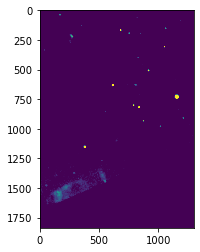

In [61]:
#paths and opening files to give the newly sub imaged image my original header info...
path_orig = 'UKIDSS/HH7_H_F_cal.fits'
path_sub = 'montage_cutouts_forallen22/hdu0HH7_H_F_cal.fits'
hdu_orig = fits.open(path_orig)
hdu_sub = fits.open(path_sub)

#center finding
filename = 'nonlincutout_656shifted_flam_0p1e-17_0_631_mic.fits'
hdu_list = fits.open(filename)[0]
crpix1 = hdu_list.header['CRPIX1']
crpix2 = hdu_list.header['CRPIX2']

from astropy.wcs.utils import pixel_to_skycoord
pixtosky_center = pixel_to_skycoord(crpix1, crpix2, WCS(hdu_list.header))


#making cutouts
wcs_header = hdu_orig[0].header

from scipy.ndimage import rotate
# f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

# ax1.imshow(hdu_orig[0].data, vmin=0, vmax=100)
data_orig_rotated = rotate(hdu_orig[0].data, -66, reshape=False)

# ax2.imshow(data_orig_rotated, vmin=0, vmax=100)
plt.close(f)

from astropy.nddata.utils import Cutout2D
cutout1 = Cutout2D(data_orig_rotated, pixtosky_center, (2000, 2000), wcs=WCS(wcs_header)) #(540, 335)
plt.imshow(cutout1.data, vmin=100, vmax=101)

fits_saver(cutout1.data, cutout1.wcs.to_header(), 'ex/HH7_H_F_cal.fits', 'tests/')

In [ ]:
#first, trying to separate out and convert to proper units for the original resolution HST images

#if applying montage to images on inanna, start here but use:
path = './UKIDSS/*'
im_names_ukidss = im_name_finder(path, 'fit') #im_finder is basically glob.glob
im_names_ukidss = [i.replace('\\', '/') for i in im_names_ukidss]

hdu_list_orig = [fits.open(i, checksum=True) for i in im_names_ukidss]

#if applying montage to images on inanna, start here but use:
path = './montage_cutouts_forallen22/hdu0HH*'   
im_names_ukidss = im_name_finder(path, 'fit') #im_finder is basically glob.glob
im_names_ukidss = [i.replace('\\', '/') for i in im_names_ukidss]

hdu_list_shrunk = [fits.open(i, checksum=True) for i in im_names_ukidss]

#initializing some lists to be used
hdu_pix_list = []
hdu_pixtorad_list = []
hdu_lam_list = []
hdu_flam_list = []
hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []

print(hdu_list)


count = 0
while count < len(hdu_list_orig): 

    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    hdu_data_list.append(hdu_data[0].data)
    hdu_header_list.append(hdu_data[0].header)
    
    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    wcs_header = hdu_data[0].header
    hdu_header_list.append(wcs_header)
    fits_saver(hdu_data_list[count], wcs_header, im_names_ukidss[count], 'montage_cutouts_forallen22/')
    
    count+=1